In [1]:
import os, yaml
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt
from openpyxl import load_workbook, Workbook
import src.paychex_ml.data_loader as dl
import src.paychex_ml.models as models

In [2]:
## Change the project path
proyect_path = "C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast"

In [3]:
# ------------------------------------------------------------------------------------- #
# This is where we change parameters to the model
# ------------------------------------------------------------------------------------- #
train_start_dt = '20140601'
train_end_dt = '20200501'
test_start_dt = '20200601'
test_end_dt = '20210501'
pred_start_dt = '20210601'
pred_end_dt = '20220101'
ml_criteria = 'MAE'
forecast_window = 8
forecast_type = '2+10'
# This is how strong you want the correlation to be in order to be included as a feature
correlation_threshold = 0.5
# This is how many features you want to keep in the final model
features_threshold = 10

In [4]:
# Set manually date if is necessary
model_run_date = datetime.today().strftime('%Y%m%d')

In [5]:
with open(proyect_path + "/src/line_items.yml", "r") as stream:
    items_dicctionary = yaml.safe_load(stream)

In [6]:
it = items_dicctionary.values()

In [7]:
file_path = proyect_path+"/data/clean/table_predictable.csv"
drive_path = proyect_path+"/data/clean/table_drivers.csv"
external_path = proyect_path+"/data/external/external_data_fred.csv"

In [8]:
ext_df = pd.read_csv(external_path, dtype={'date': str})\
    .rename(columns={'date': 'Calendar Date'})

In [11]:
alphas = [0.15, 0.1, 0.05, 0.01]

Shape of the training dataframe:  (72, 1699)
Shape of the testing dataframe:  (12, 1699)
Shape of the combination dataframe:  (84, 1699)
############################  Running Auto ARIMA for Total Payroll Revenue.   ############################
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2592.607, Time=0.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2620.949, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2599.710, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2591.230, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2601.867, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2590.121, Time=0.17 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2596.571, Time=0.09 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2590.557, Time=0.41 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2591.151, Time=0.57 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2589.152, Time=0.33 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=

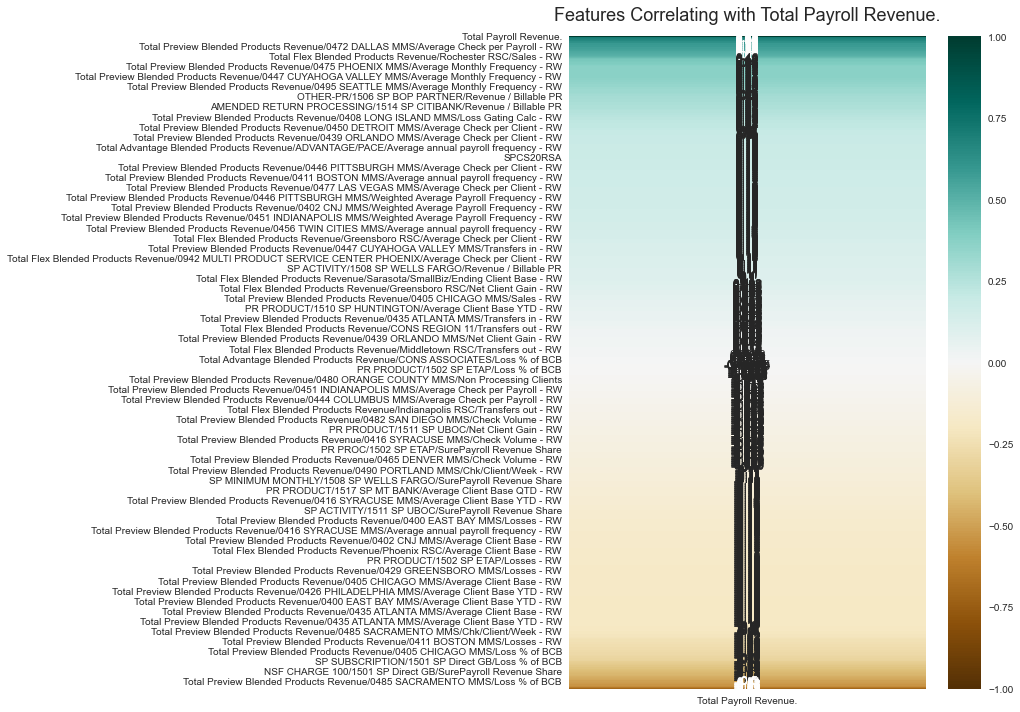

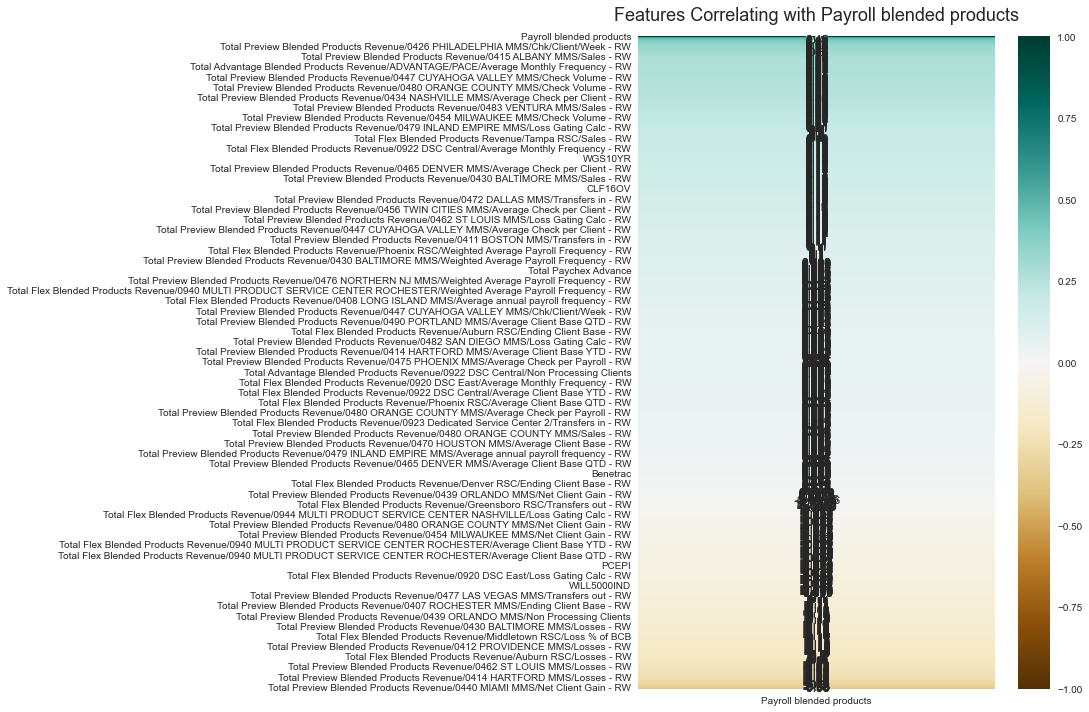

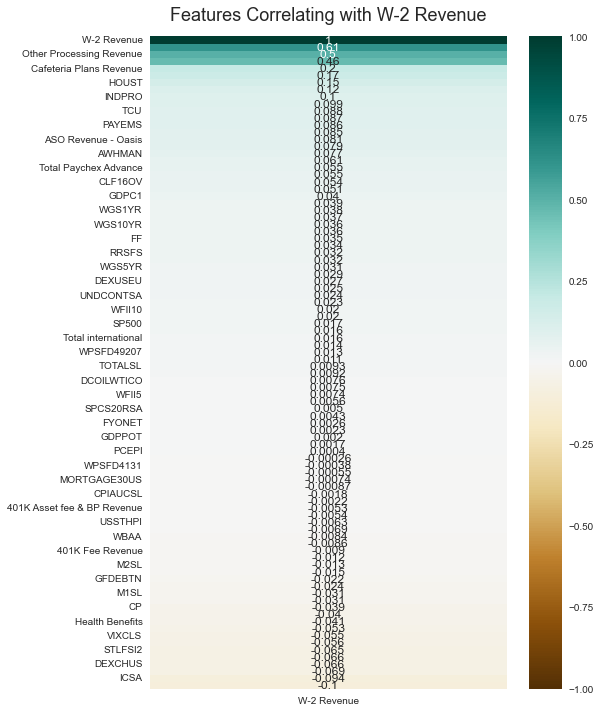

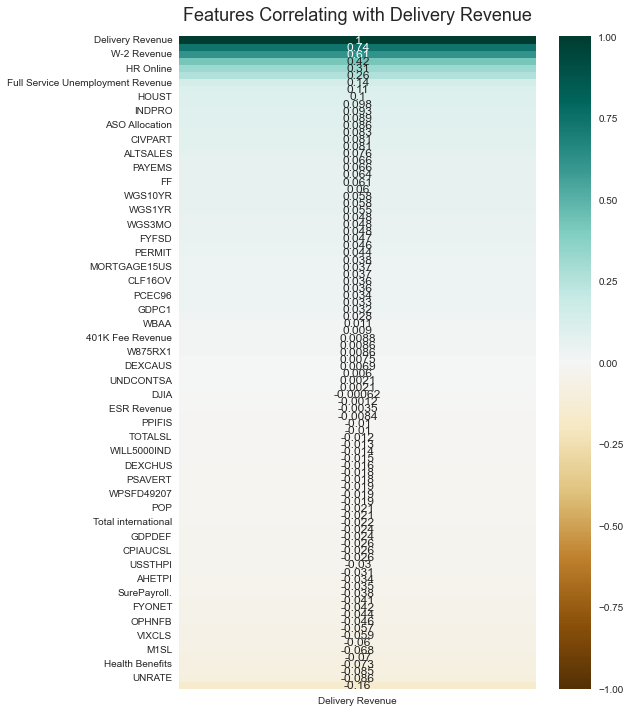

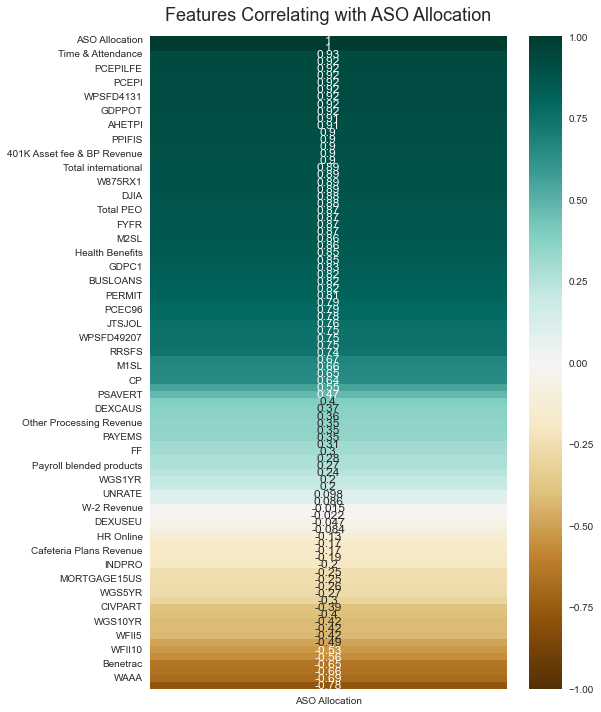

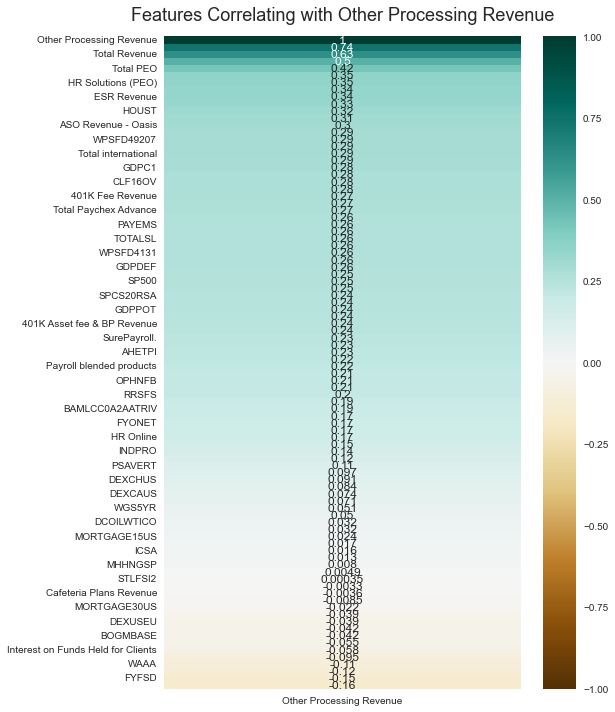

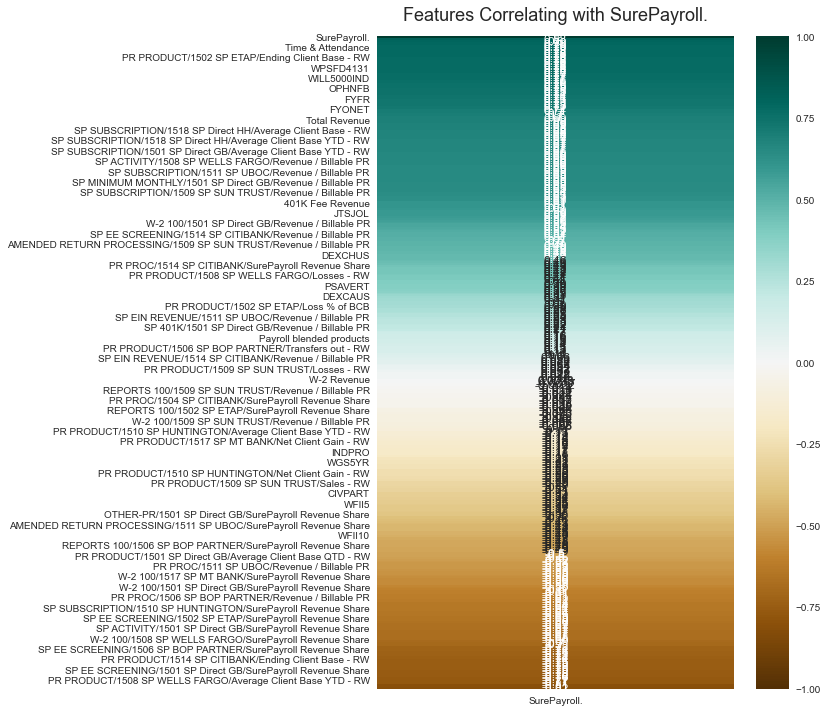

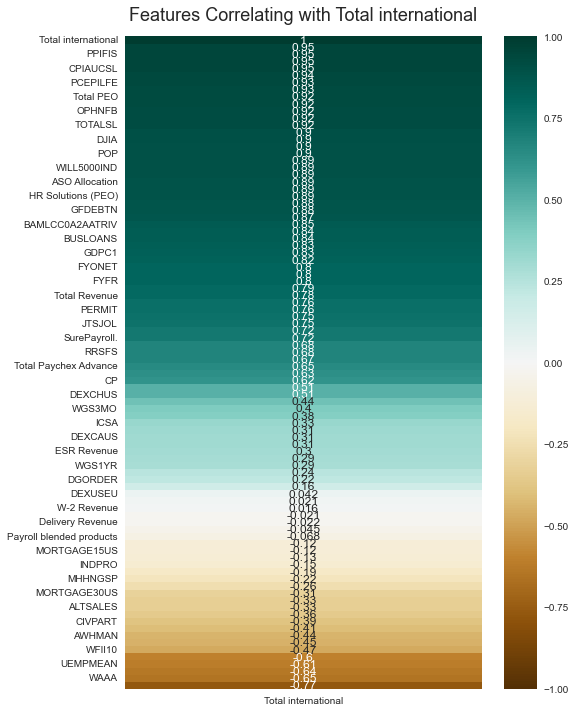

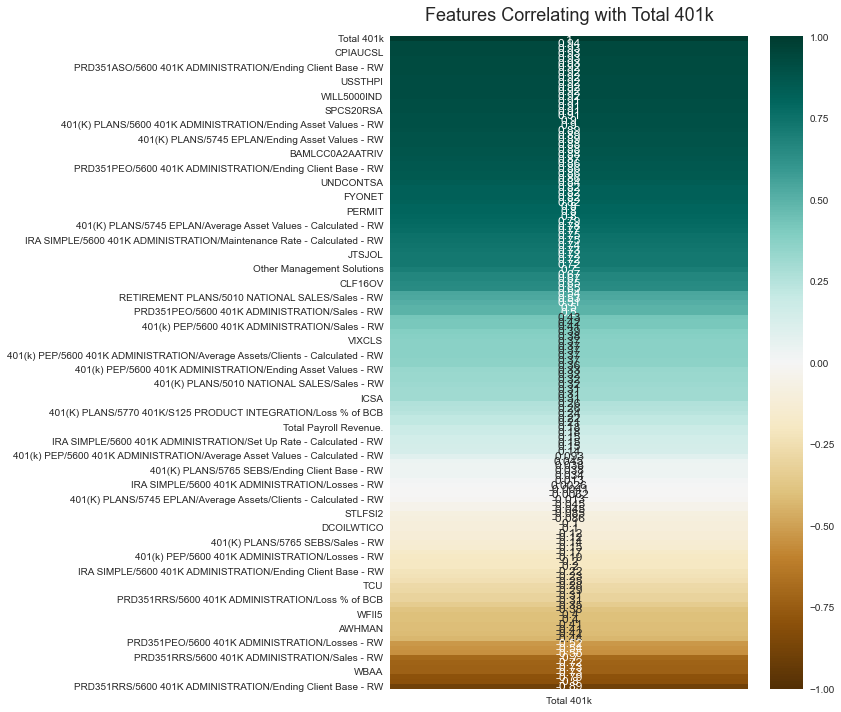

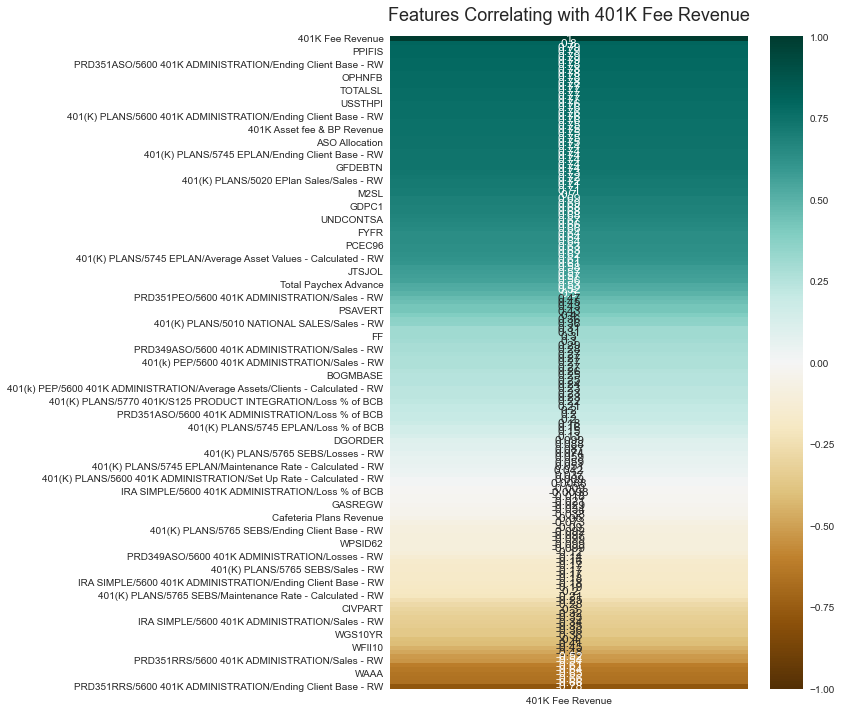

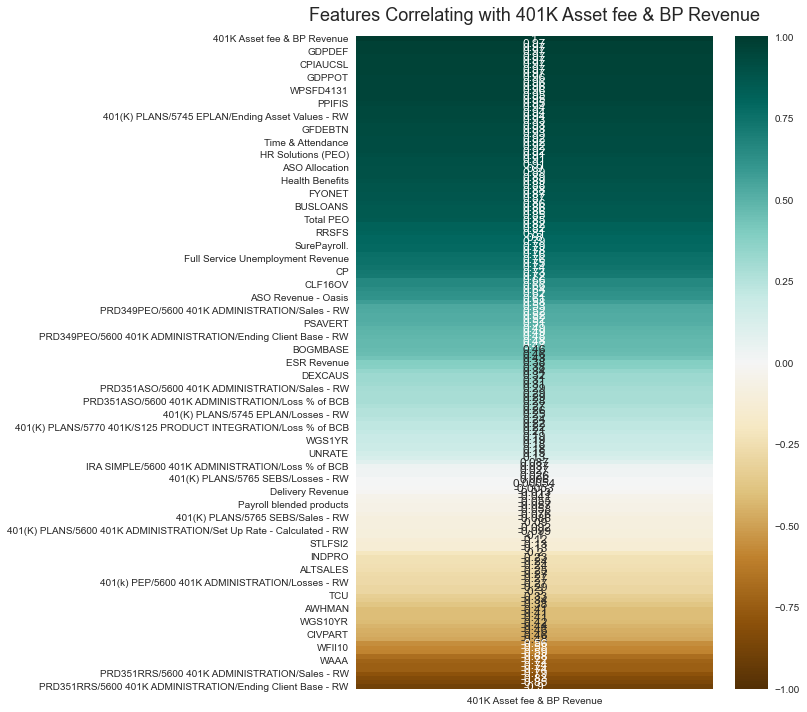

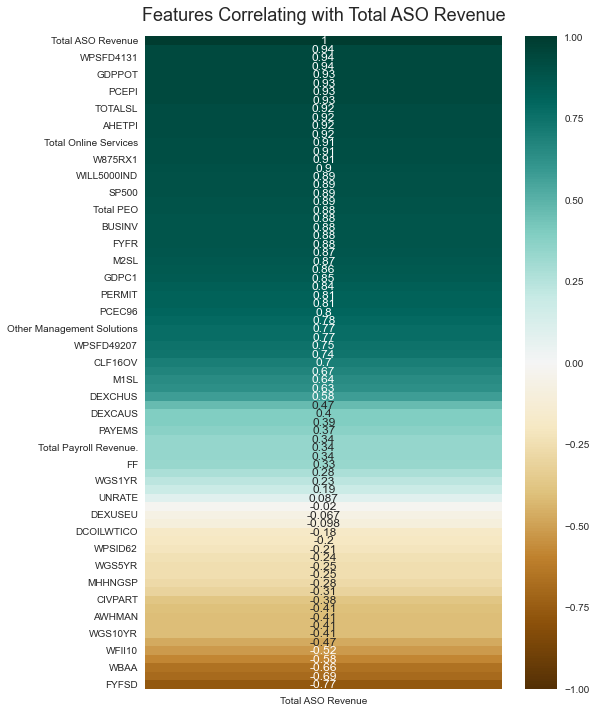

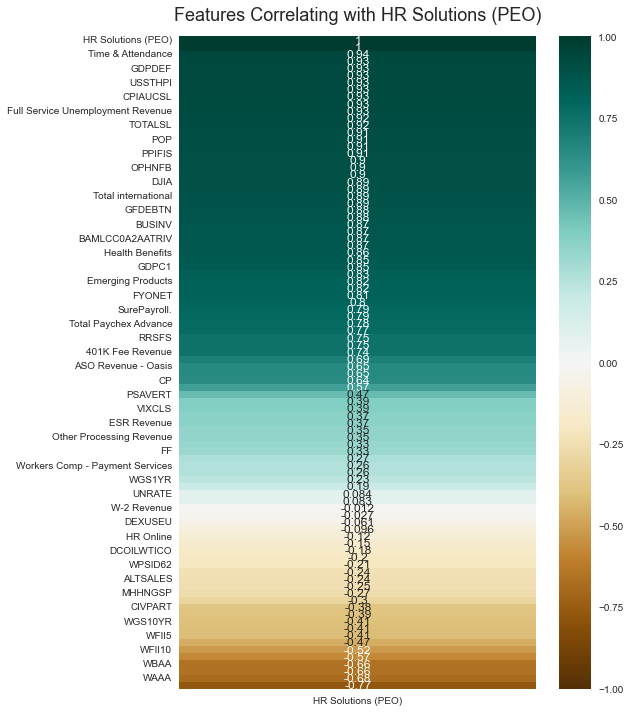

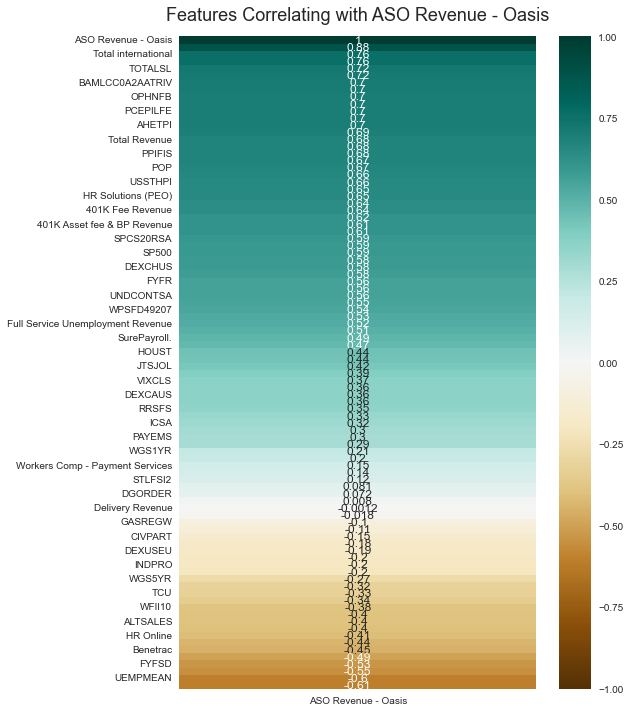

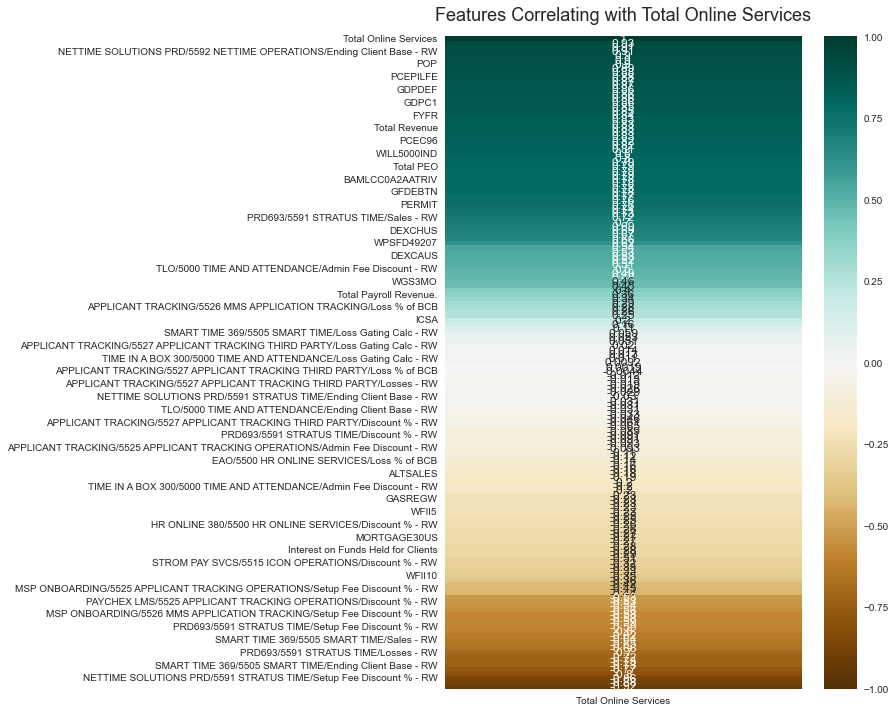

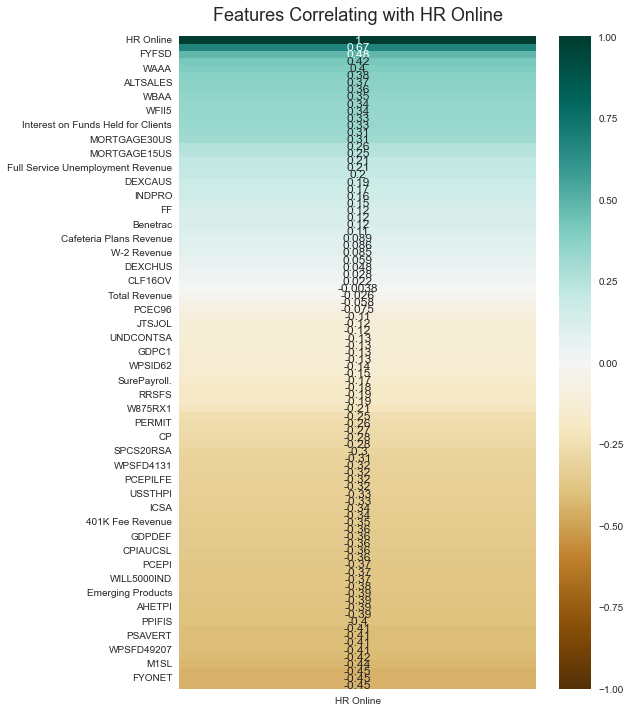

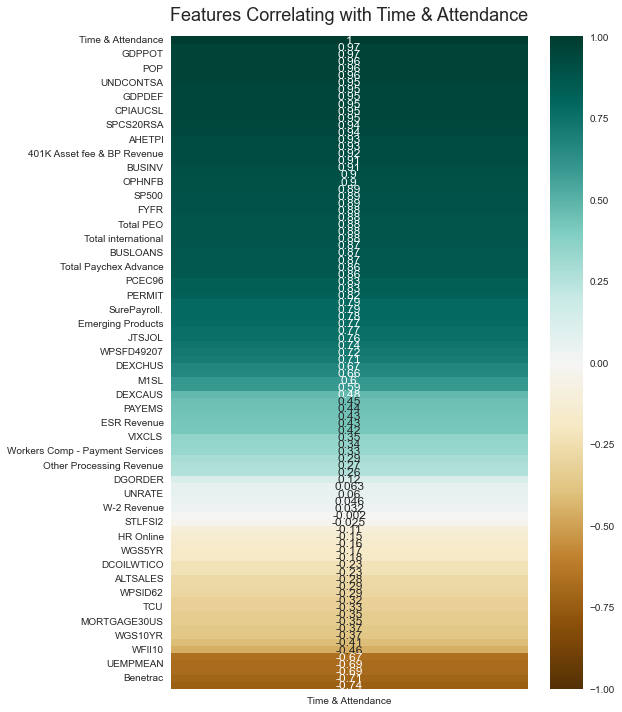

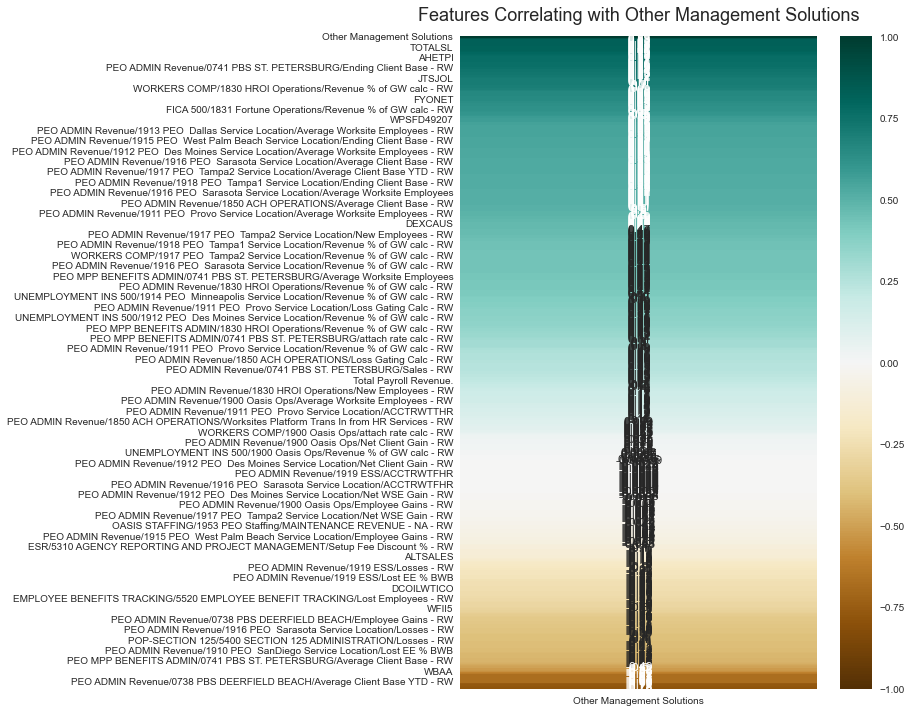

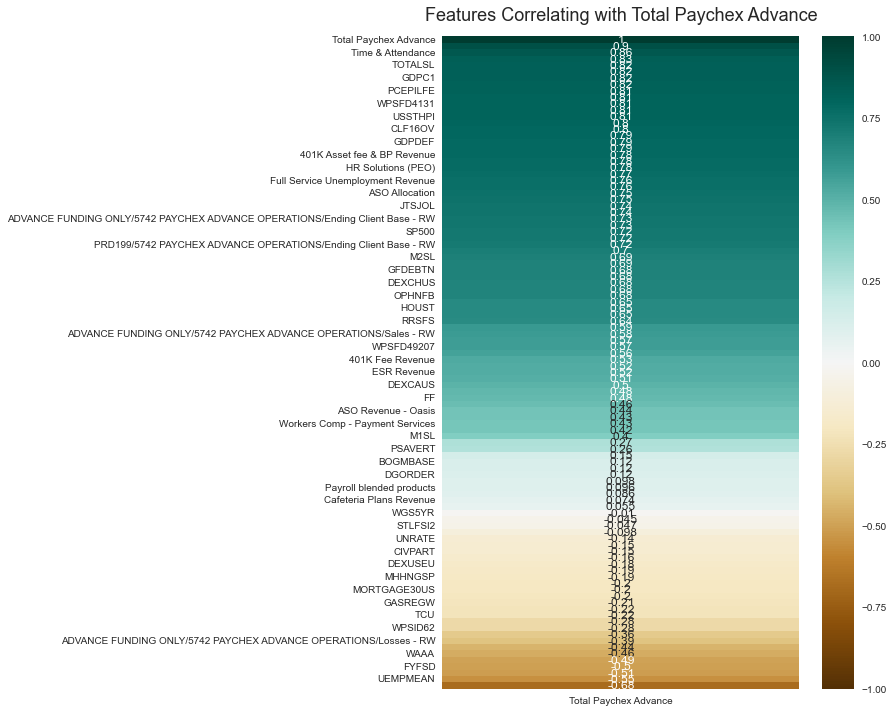

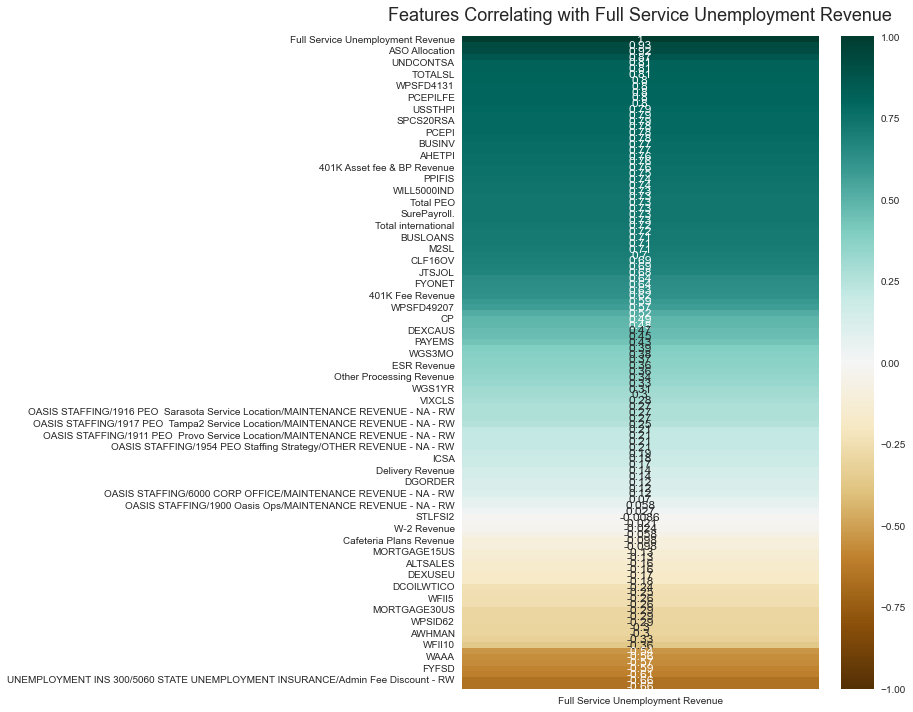

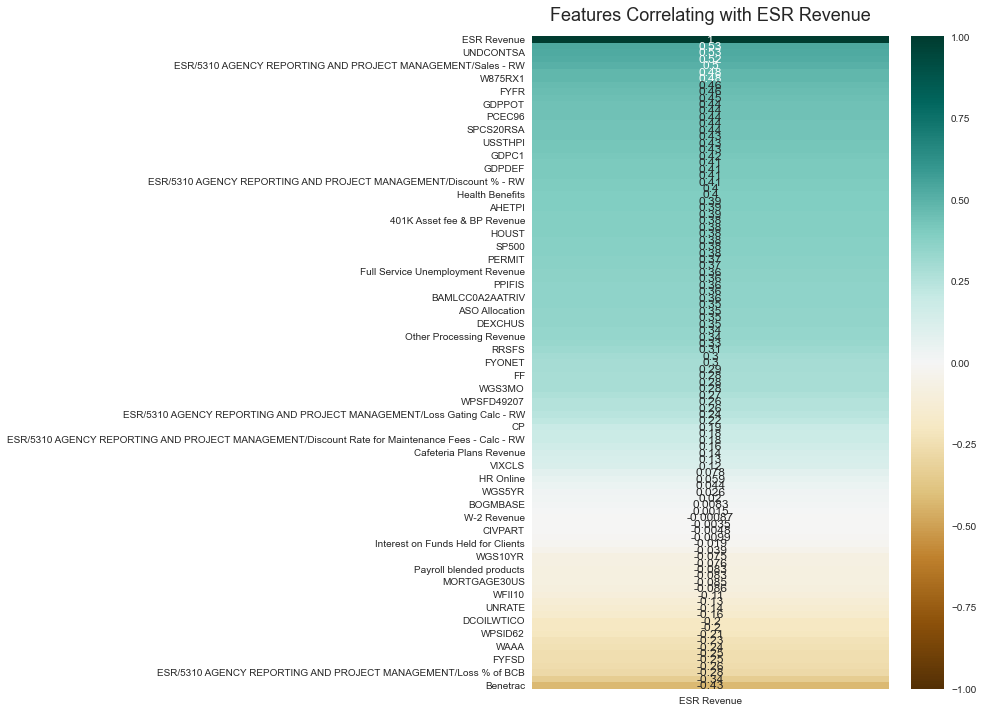

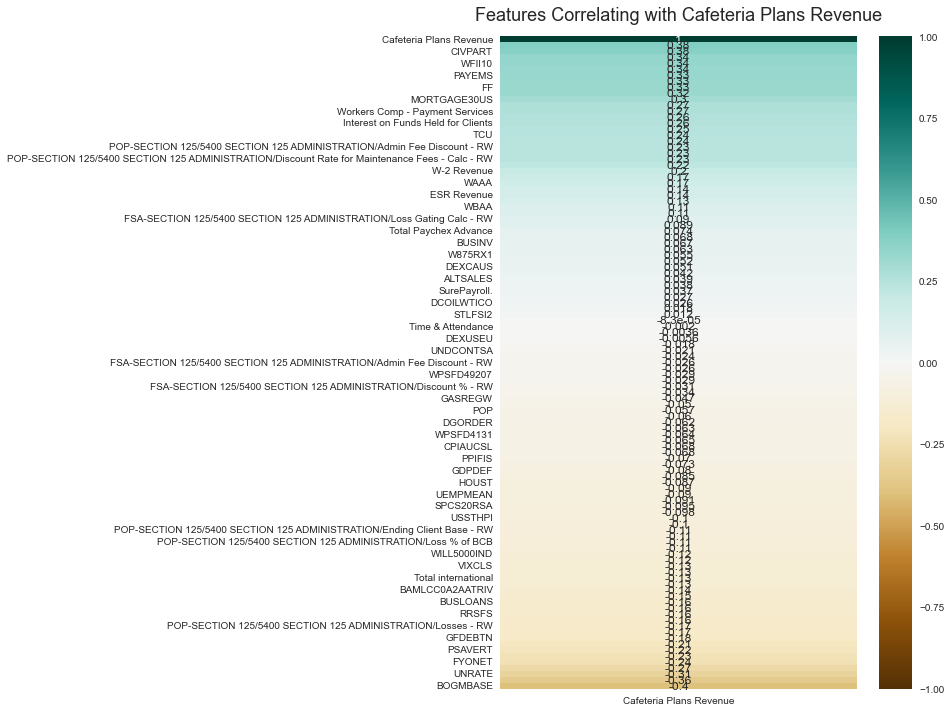

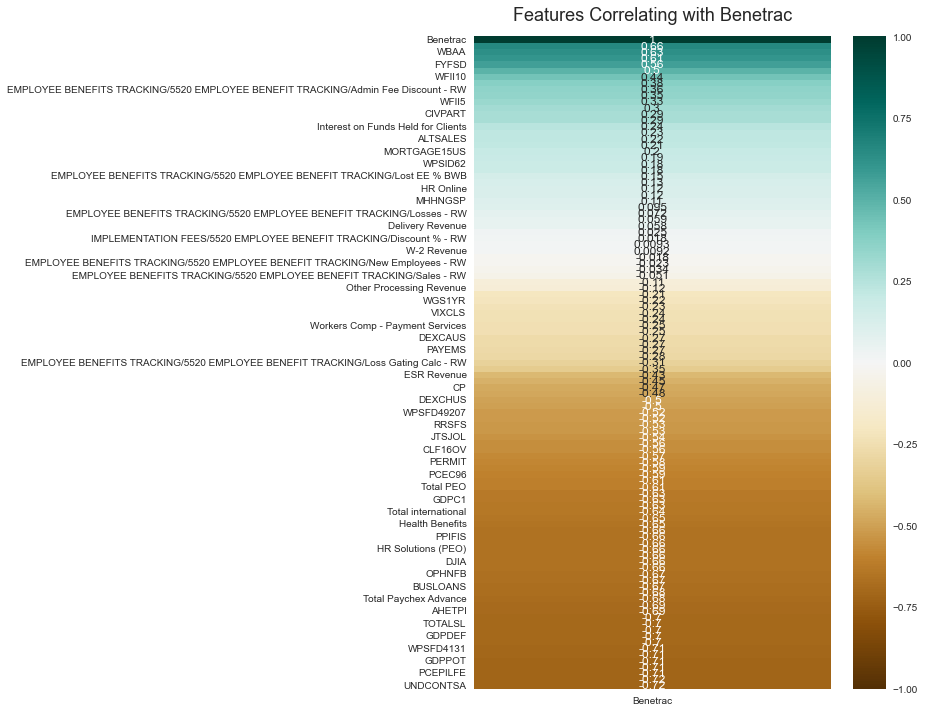

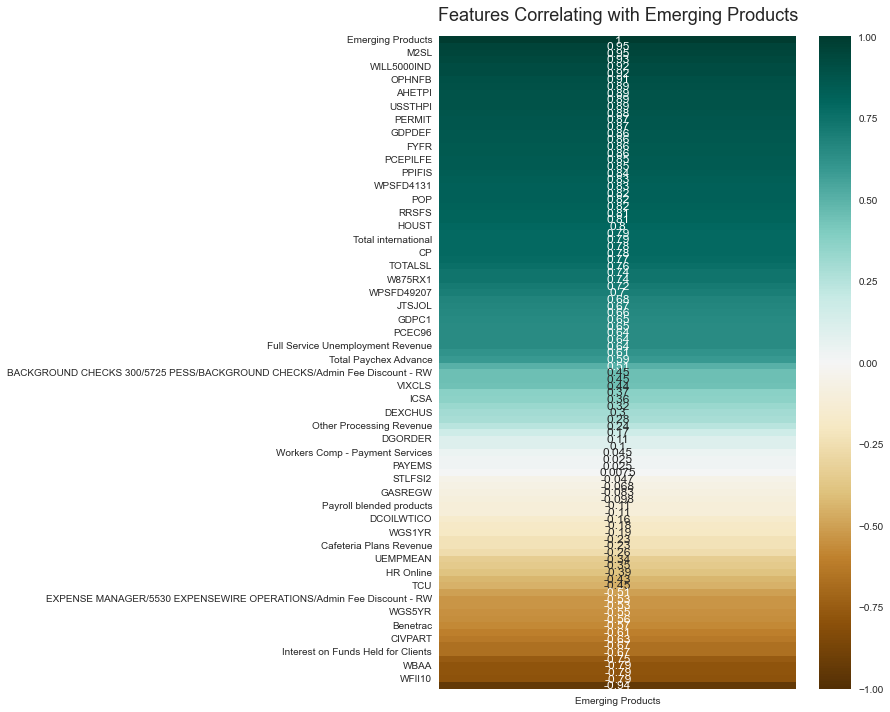

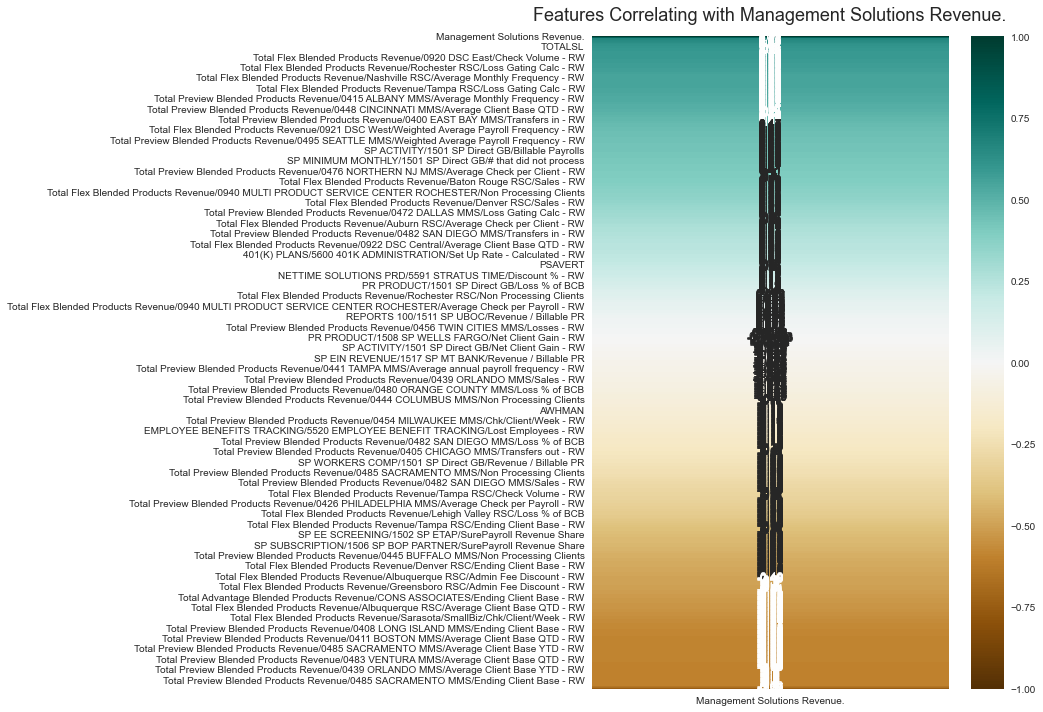

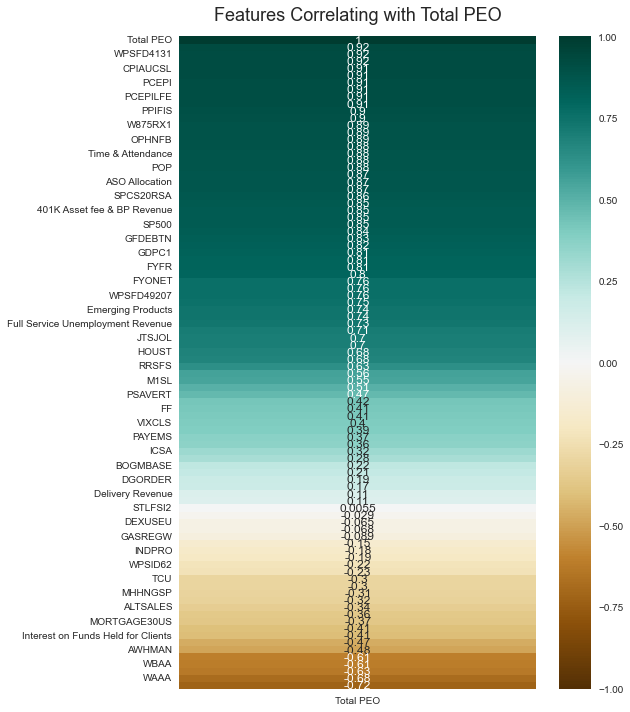

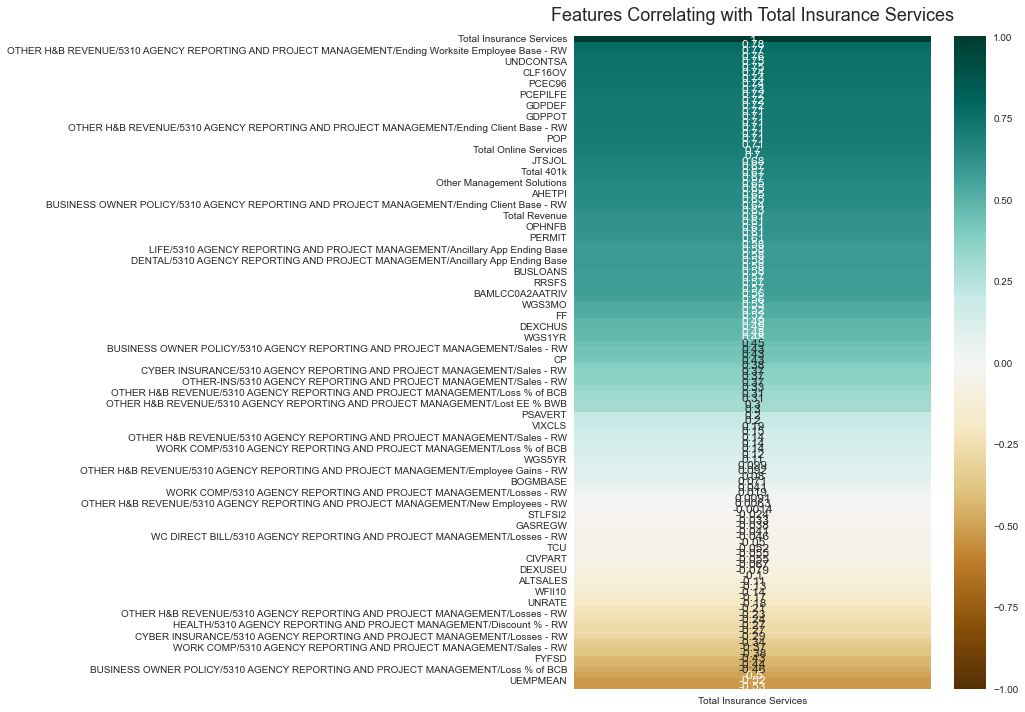

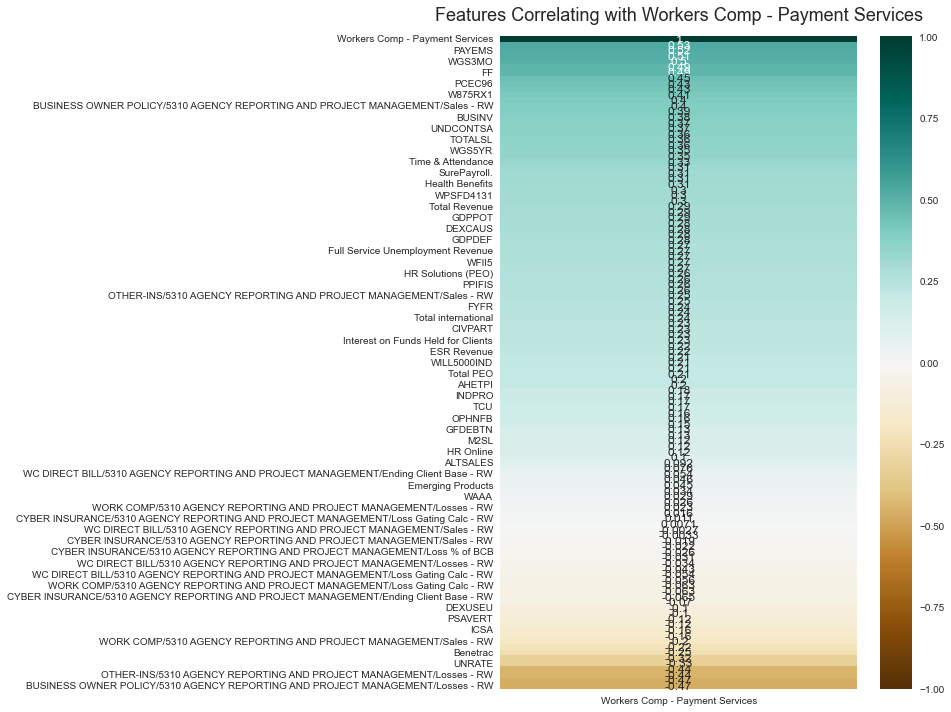

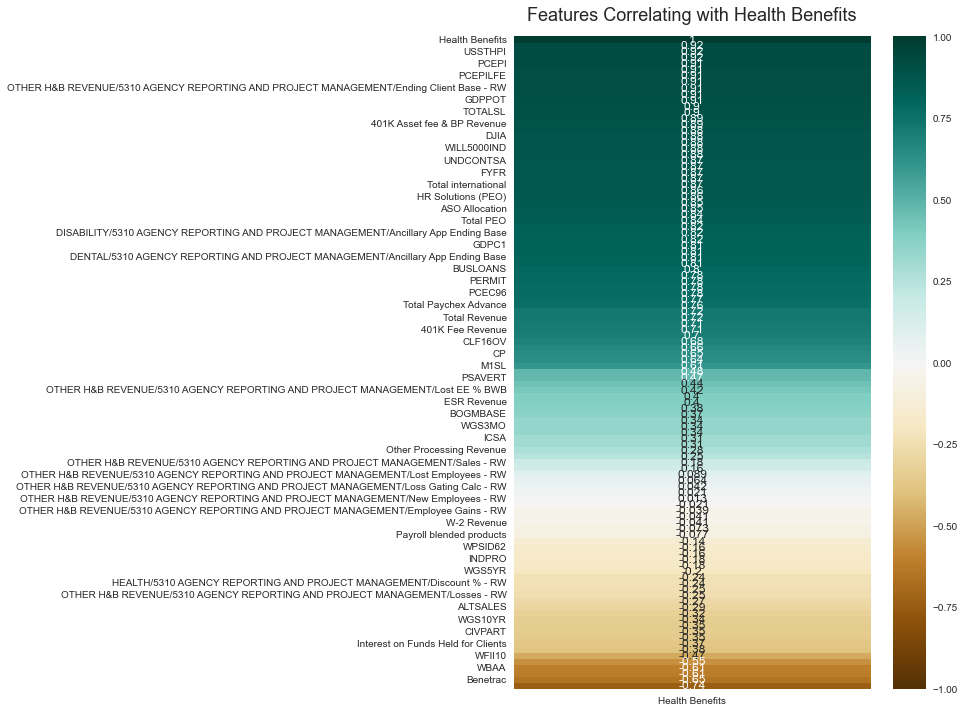

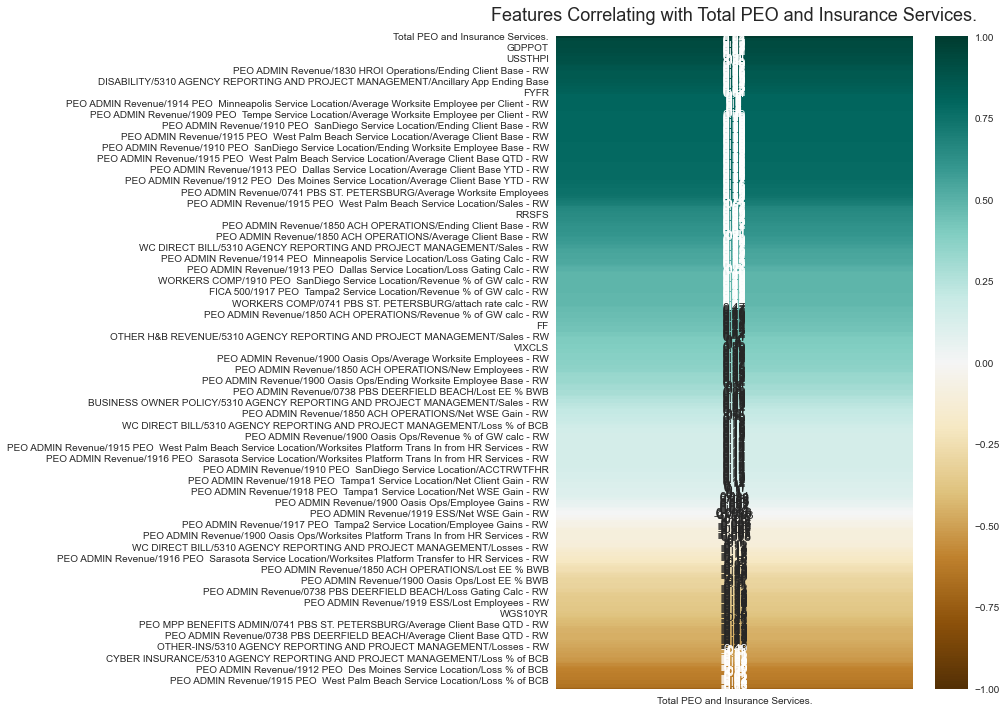

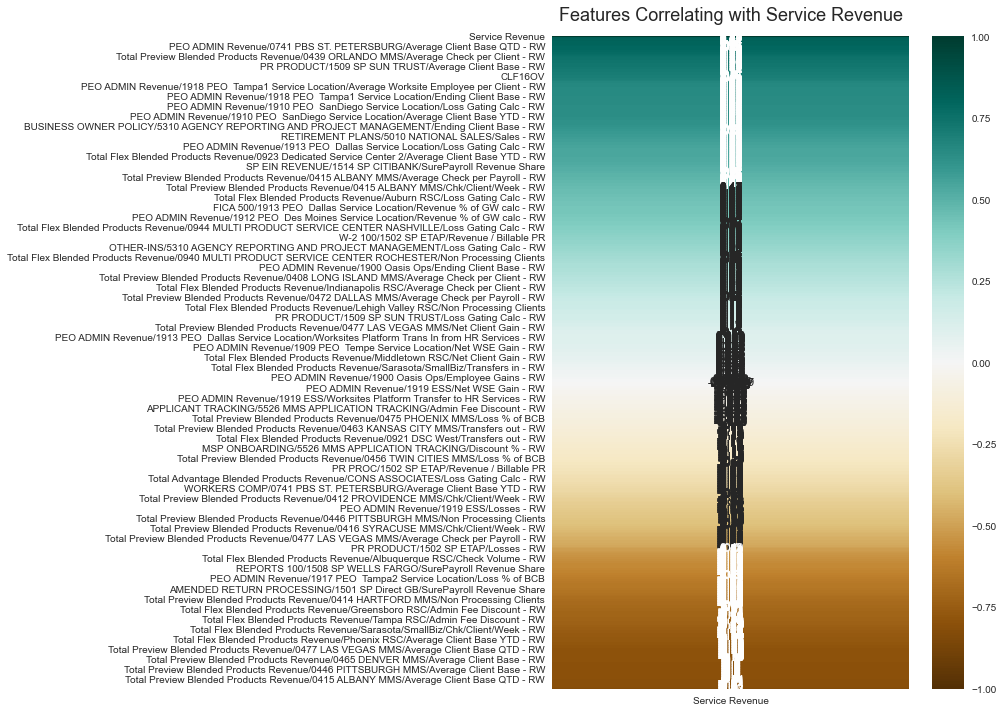

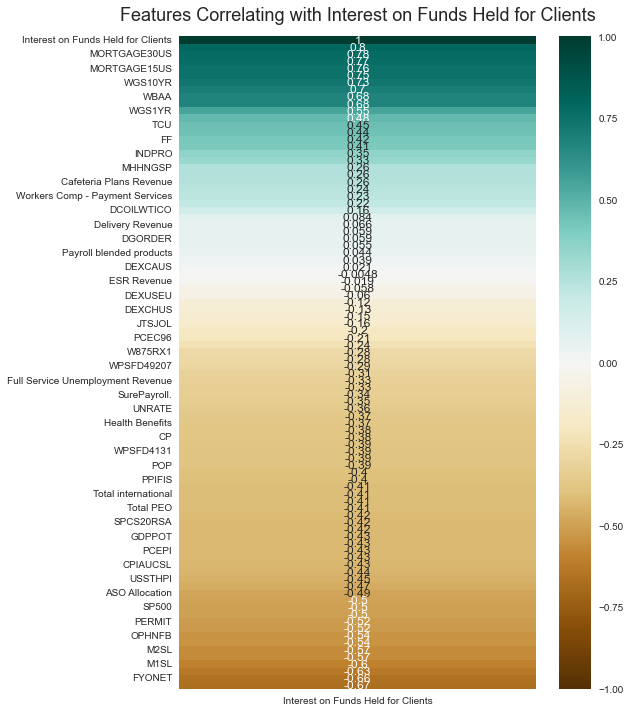

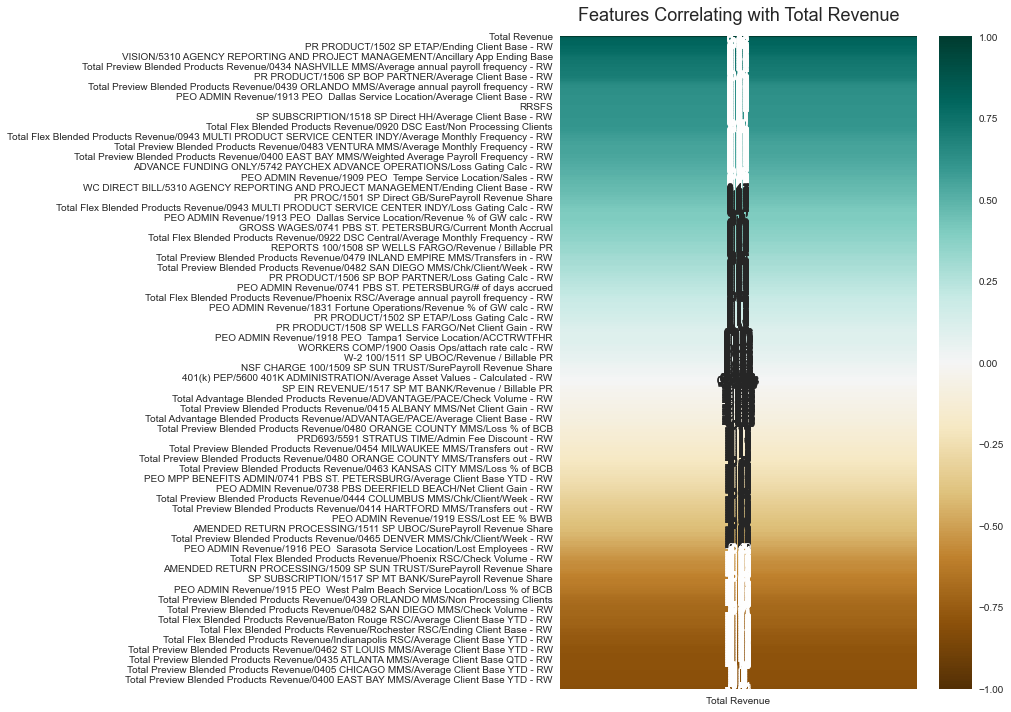

In [12]:
for target_col, has_drivers, level in it:

    all_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path, level=level)
    all_df = pd.merge(all_df, ext_df, on='Calendar Date', how='inner')

    if has_drivers:
        driv_df = dl.get_clean_driver_data(train_start_dt, pred_end_dt, target_col, drive_path)
        all_df = pd.merge(all_df, driv_df, on='Calendar Date', how='inner')

    train_df, test_df, comb_df = models.train_test_combine_split(all_df, train_end_dt, test_start_dt, test_end_dt)
    corr_feature_cols, fig = models.features_correlation(comb_df, target_col, 0, save_path="./")

    utf = []

    for alpha in alphas:
        uts_pred, _ = models.run_auto_arima(comb_df[['Calendar Date', target_col]],
                                          [target_col], pred_start_dt, forecast_window, ci=True, alpha = alpha)
        uts_pred = uts_pred.set_index('Calendar Date')
        utf.append(uts_pred)

    utf_final = pd.concat(utf, axis=1)

    intervals_path = "./intervals.xlsx"
    if os.path.exists(intervals_path):
        book = load_workbook(intervals_path)
    else:
        book = Workbook()
    with pd.ExcelWriter(intervals_path, engine = 'openpyxl') as writer:
        writer.book = book
        utf_final.to_excel(writer, sheet_name = target_col[0:30])